In [1]:
#initialize
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Import data

In [2]:
df = pd.read_csv('data/HCA.csv')
df['Date'] = pd.to_datetime(df.Date)
df.head(2)
df.shape

# quandl doesn't offer current year?
# df = pd.read_csv('https://www.quandl.com/api/v3/datasets/WIKI/AAPL.csv')
# df.Date.max()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-03-07,31.200001,31.500000,30.500000,31.120001,24.494720,74131500
1,2011-03-14,30.959999,33.080002,30.360001,33.060001,26.021708,30738500


(430, 7)

# Approach: isolation forest

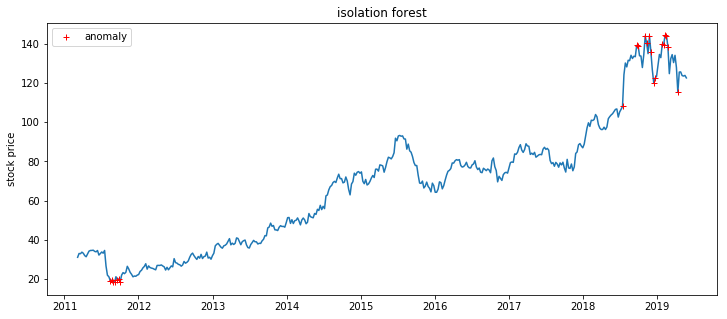

In [3]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(behaviour='new',contamination=.05,random_state=42)
X = df.Close.values.reshape(-1, 1)
model.fit(X)
df['normal'] = model.predict(X)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig = plt.figure(figsize=(12,5))
plt.plot(df.Date,X)
plt.plot(df[df.normal!=1].Date,df[df.normal!=1].Close,'r+',label='anomaly')
plt.ylabel('stock price')
plt.gca().set_title('isolation forest')
plt.legend();

# local outlier factor

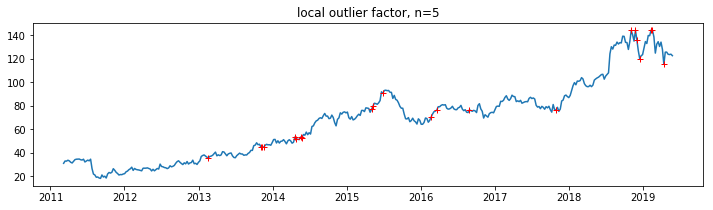

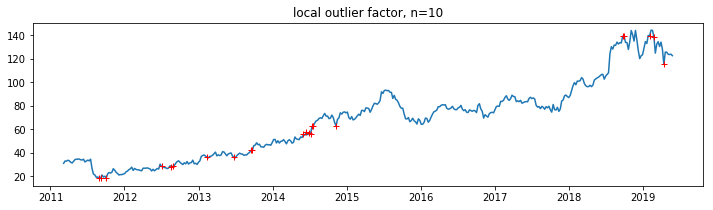

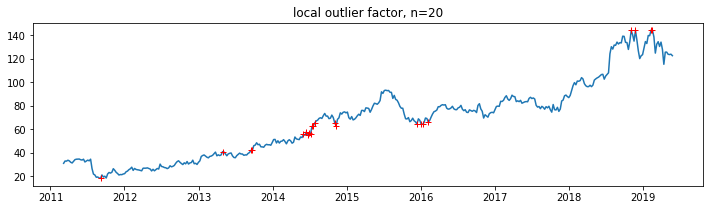

In [4]:
from sklearn.neighbors import LocalOutlierFactor

for n in [5,10,20]:

    clf = LocalOutlierFactor(n_neighbors=n, contamination=0.05)
    y_pred = clf.fit_predict(X)
    anomalies = [a if b==-1 else np.nan for a,b in zip(df.Close,y_pred)]

    fig = plt.figure(figsize=(12,3))
    _=plt.plot(df.Date,X);
    _=plt.plot(df.Date,anomalies,'r+');
    _=plt.gca().set_title('local outlier factor, n={}'.format(n));

# Approach: GRU

In [5]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def genForecast(series):
       
    # series = df.Close
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(series.values.reshape(-1,1))

    series = pd.DataFrame(scaled)
    series_s = series.copy()
    window_size = 8
    for i in range(window_size):
        series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)

    series.dropna(axis=0, inplace=True)

    #split
    train_X = series.values[:,:-1]
    # test_X = series.values[cutoff:,:-1]

    #reshape to 3d as req'd by lstm
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    # test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

    train_y = series.values[:,-1]
    # test_y = series.values[cutoff:,-1]

    # Define the model
    model = Sequential()
    model.add(GRU(input_shape = (window_size,1), units= window_size, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(GRU(56))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse", optimizer="adam")
    # model.summary()

    model.fit(train_X,train_y,epochs=5,validation_split=0.1)
    # ,batch_size=512)

    # preds = model.predict(test_X)
    preds = model.predict(train_X)
    preds = scaler.inverse_transform(preds)
    
    #front load with no prediction as gru /lstm uses the first window size to gen a prediction
    preds = np.concatenate((np.full(window_size,np.nan),preds.reshape(-1)))
    
    return preds
    # mean_squared_error(actuals,preds)

Using TensorFlow backend.


In [6]:
df['yhat'] = genForecast(df.Close)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 379 samples, validate on 43 samples
Epoch 1/5
379/379 [==============================] - 4s 11ms/step - loss: 0.2015 - val_loss: 0.4758
Epoch 2/5
379/379 [==============================] - 1s 2ms/step - loss: 0.0628 - val_loss: 0.2280
Epoch 3/5
379/379 [==============================] - 1s 2ms/step - loss: 0.0405 - val_loss: 0.1093
Epoch 4/5
379/379 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0338
Epoch 5/5
379/379 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0154


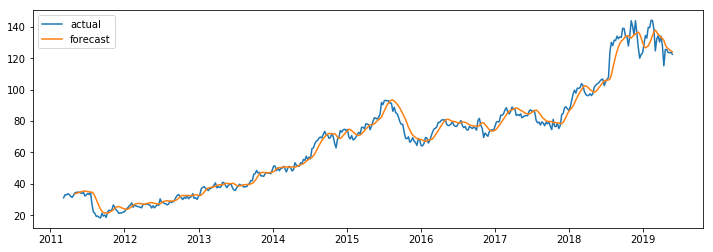

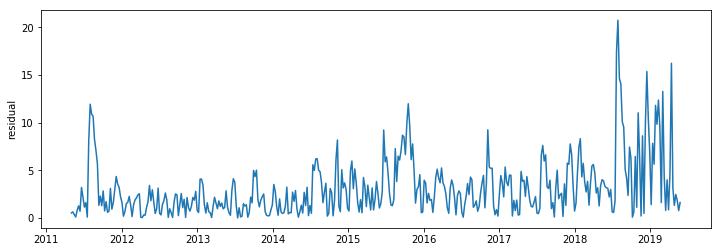

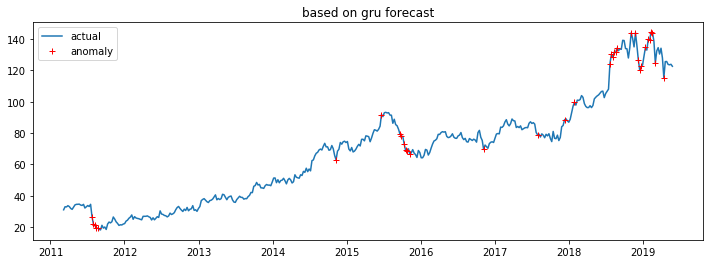

In [7]:
fig = plt.figure(figsize=(12,4))
_= plt.plot(df.Date,df.Close,label='actual')
_= plt.plot(df.Date,df.yhat,label='forecast')
_= plt.legend();


df['residual'] = abs(df.yhat - df.Close)

fig = plt.figure(figsize=(12,4))
_= plt.plot(df.Date,df.residual)
_= plt.ylabel('residual')

outliers = int(df.shape[0] * .1)
topResid = np.sort(df.residual)[-outliers:]
df['anomaly'] = [r.Close if np.isin(df.residual[r.Index],topResid) else np.nan for r in df.itertuples()]


fig = plt.figure(figsize=(12,4))
_=plt.plot(df.Date,df.Close,label='actual')
_=plt.plot(df.Date,df.anomaly,'r+',label='anomaly');
_=plt.gca().set_title('based on gru forecast');
_= plt.legend();

# K nearest neighbors

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

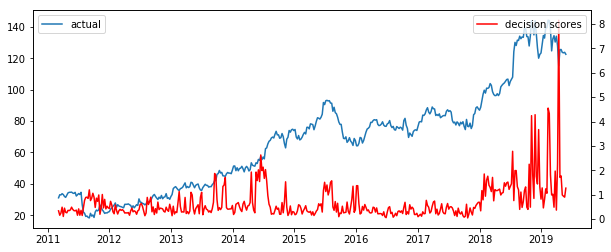

In [8]:
# using outlier detection package
from pyod.models.knn import KNN

clf = KNN(n_neighbors=5)
clf.fit(df.Close.values.reshape(-1,1))

fig = plt.figure(figsize=(10,4))
ax = fig.gca()
_ = ax.plot(df.Date,df.Close,label='actual')

ax2 = fig.gca().twinx()
_ = ax2.plot(df.Date,clf.decision_scores_,'r',label='decision scores')

_ = ax.legend()
_ = ax2.legend(loc='upper right')


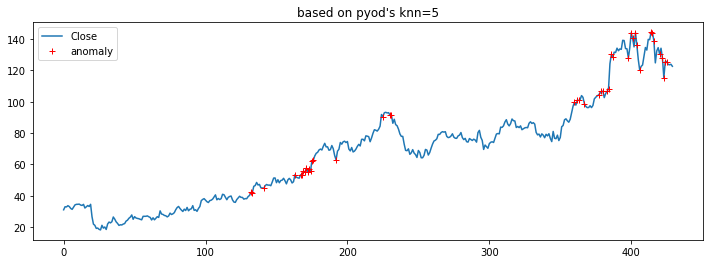

In [9]:

highestScores = np.sort(clf.decision_scores_)[-outliers:]

df['anomaly'] = [r.Close if np.isin(clf.decision_scores_[r.Index],highestScores) 
                 else np.nan for r in df.itertuples()]

fig = plt.figure(figsize=(12,4))
_=plt.plot(df.Close)
_=plt.plot(df.anomaly,'r+',label='anomaly')
_=plt.gca().set_title('based on pyod\'s knn=5');
_= plt.legend();
